## As our data depends on time, we are going to analyze it as a Time Series.

### Import libraries

In [1]:
import pandas as pd
import itertools
import statsmodels.api as sm
from pylab import rcParams

#To plot
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
cf.go_offline()

### Import and check the data

In [2]:
data = pd.read_csv('../Data/Oni_simplified_region_label.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
0,5796,1983,10,30,1983-10-30,-0.04,-124.54,-1.9,0.9,NaN,21.56,NaN,0
1,5797,1983,10,31,1983-10-31,-0.04,-124.54,-1.5,1.0,NaN,21.56,NaN,0
2,5798,1983,11,1,1983-11-01,-0.04,-124.54,-1.9,-0.1,NaN,21.64,NaN,0
3,5799,1983,11,2,1983-11-02,-0.04,-124.54,-0.9,-0.4,NaN,22.01,NaN,0
4,5800,1983,11,3,1983-11-03,-0.04,-124.54,-1.6,0.8,NaN,22.21,NaN,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 13 columns):
obs           13080 non-null int64
year          13080 non-null int64
month         13080 non-null int64
day           13080 non-null int64
date          13080 non-null datetime64[ns]
latitude      13080 non-null float64
longitude     13080 non-null float64
zon.winds     12121 non-null float64
mer.winds     12121 non-null float64
humidity      6256 non-null float64
air temp.     11524 non-null float64
s.s.temp.     11864 non-null float64
buoy_label    13080 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 1.3 MB


In [5]:
data.isnull().sum()

obs              0
year             0
month            0
day              0
date             0
latitude         0
longitude        0
zon.winds      959
mer.winds      959
humidity      6824
air temp.     1556
s.s.temp.     1216
buoy_label       0
dtype: int64

### Group the data by date and plot the data to see a first glimpse of it

In [6]:
g = data.groupby(by='date').mean()

In [7]:
g.shape

(5274, 12)

In [8]:
g.isnull().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds        2
mer.winds        2
humidity      2402
air temp.      287
s.s.temp.      165
buoy_label       0
dtype: int64

In [9]:
g['zon.winds'].rolling(window= 30).mean().iplot(kind='line', xTitle='Time',
           yTitle='Zonal Winds (m/s)', title='Zonal Winds between 1983 and  1998')

### Clean and take the data for the analysis

#### We group our data by date, resampling it by months and check nan values.

In [14]:
y = data.groupby(by='date').mean().resample('MS').mean()['zon.winds']
y.isnull().sum()

7

#### If, we then only take values from October 1983, we can avoid some nan values that are present in the data set. 

In [15]:
y[y.index > '1983-10-01'].isnull().sum()

2

#### I fill the 2 nan values of 1987-03-01 and 1987-04-01 with the intermediate values of 27.720290 and 28.092553.


In [17]:
y['1987-03-01'] = -4.34413
y['1987-04-01'] = -2.44913

#### If, we then only take values from October 1983, we can avoid some nan values that are present in the data set. 

In [18]:
y[y.index > '1983-10-01'].isnull().sum()

0

In [19]:
y_rev = y[y.index > '1985-10-01']

#### Finally, we plot the cleaned and ready-to-analyze data

In [20]:
y_rev.iplot(kind='line', xTitle='Time',
           yTitle='Zonal Winds (m/s)', title='Meridional between 1984 and  1998')

## Decomposition Analysis

#### Decompose the time-series into three distinct components: trend, seasonality and noise

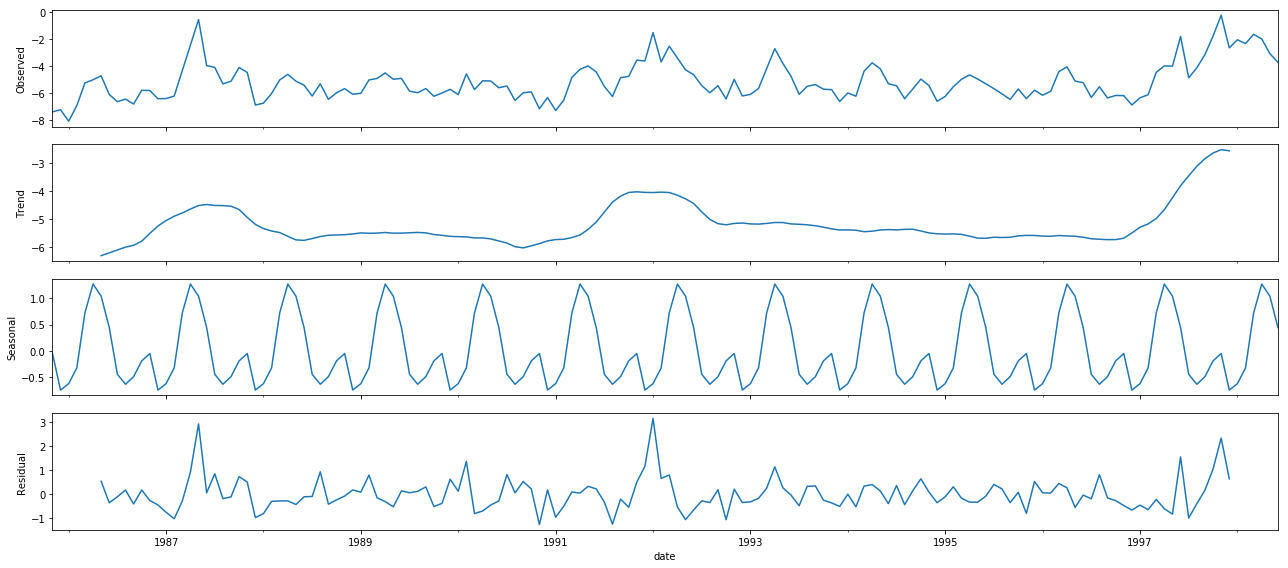

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='additive')
fig = decomposition.plot()
plt.show()

## SARIMAX method

Autoregressive Integrated Moving Average, or ARIMA is a well established method for Time Series Analysis. However, it does not support seasonal data. As our data has seasonal components, we will use seasonal ARIMA or SARIMA instead. 

Moreover, ARIMA and SARIMA are only valid to stationary data. As the meteorological data we have tends to repeat over years (we will discard any climate change effect), we can considered it stationary. 

 Therefore, in order to analyze and forecast the meridional winds vs Time, we use the SARIMAX method.
The additional X means that the method is able to manage exogenous variables (variables that are not affected by others variables in the method). However, in this analysis we are not going to use them.

First, we need to find the most optimal SARIMAX parameters that fits with our data. To do so, we generate a combination of parameters that will be evaluated with our data. 

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets. As our data is structured in months, we set a 12 as the periodicity. 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [24]:
# Two for loops in order to try pdq and seasonal pdq parameters.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_rev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:935.6468861263966
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:736.7139009236955
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:537.1128924361069
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:439.46253619272693
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:528.996791758369
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:474.28786712620615
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:463.70320529675047
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:448.7319899151414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:767.7811556671206
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:611.9715026925003
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:472.5023746865219
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:385.1083464012428
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:467.27538763150994
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:419.068445853246
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:414.1058344966755
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:396.61330465395696
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:423.3417306300491
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:386.27392916106646
ARIMA(

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:369.38591836711805
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:362.13910541790347
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:338.2148831904467
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:422.71509292559466
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:385.3974811205164
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:416.1197688955921
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:326.9620626120886
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:379.7558569957073
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:360.9290857756598
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:358.58122130946316
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:328.9621595715266
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:422.53215836395486
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:384.5453464795968
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:424.7346651075894
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:331.70300618558053
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:377.17114528246435
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:361.4330334282738
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:358.1048744183384
ARI

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Thus, the parameters that are related to our most optimal fit are:

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:326.9620626120886

#### Fitting the SARIMAX model with the previously found values. 

In [25]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_rev,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarimax_model.fit()

# We plot the result summary
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                          zon.winds   No. Observations:                  152
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -159.481
Date:                            Wed, 24 Apr 2019   AIC                            326.962
Time:                                    09:29:33   BIC                            338.307
Sample:                                11-01-1985   HQIC                           331.571
                                     - 06-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8699      0.065     13.334      0.000       0.742       0.998
ma.L1         -0.2841      0.122   

#### In order to visualize check the fitness of our model, we plot the diagnostics graphs.

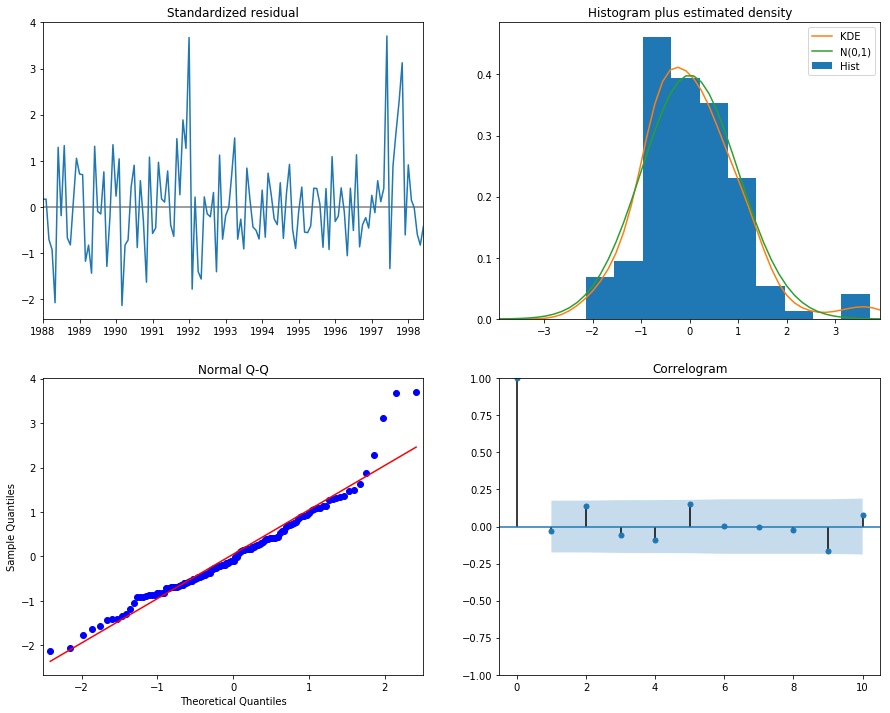

In [26]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), except for the first and last section of the regression. Again, this is an indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.


### Model prediction. 
#### We predict the meridional winds of the last years of data. 

In [28]:
pred = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

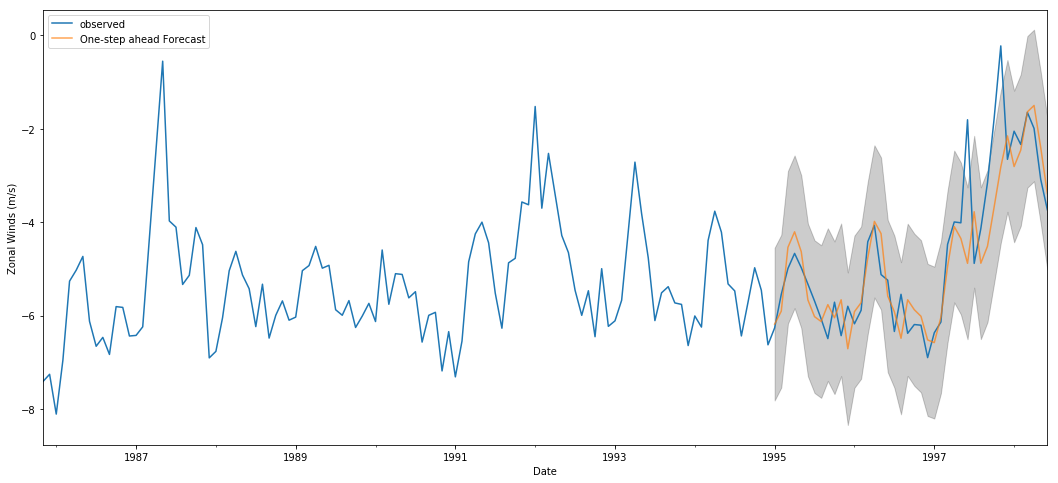

In [29]:
ax = y_rev['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Zonal Winds (m/s)')
plt.legend()


plt.show()


#### Model accuracy. 
We will use the MSE (Mean Squared Error) which summarize the average error of our forecasts. 

In [30]:
y_forecasted = pred.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.75


However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

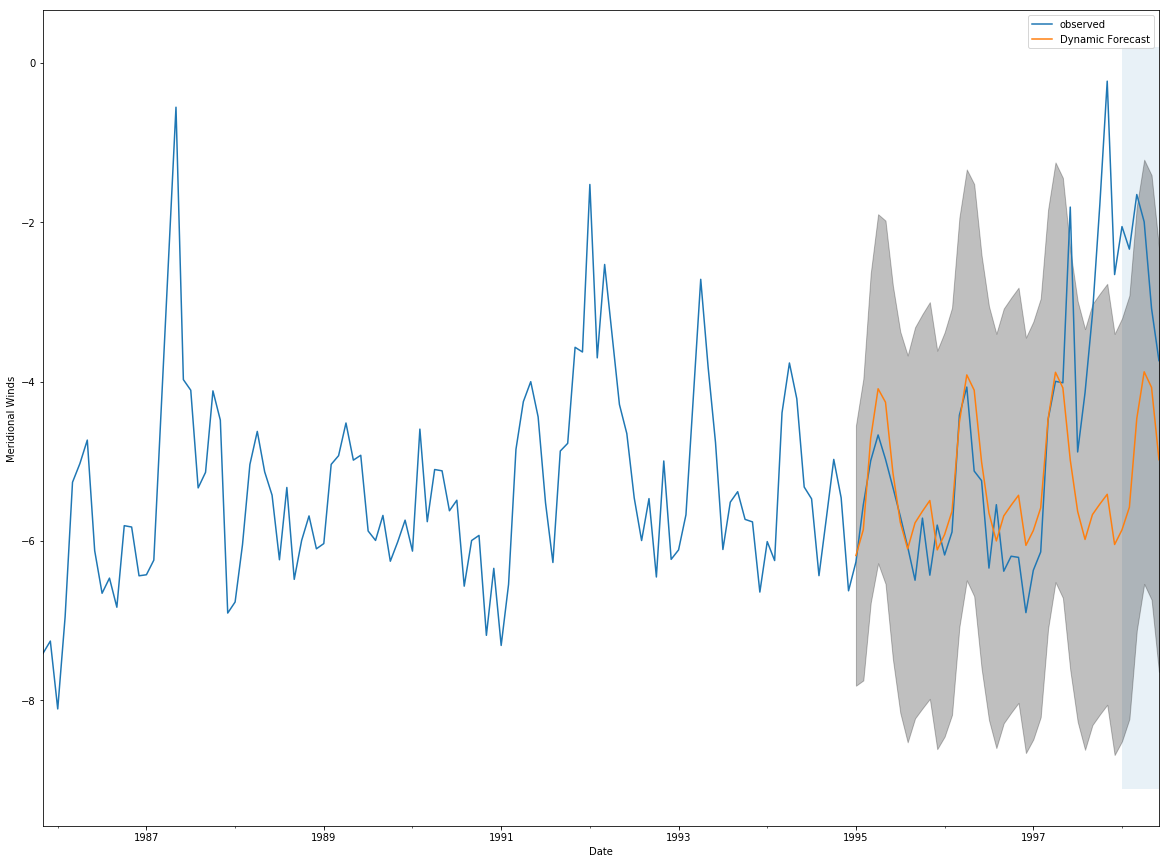

In [31]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1998-01-01'),
                 y_rev.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Meridional Winds')

plt.legend()
plt.show()

In [32]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_rev['1995-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2.9


The MSE is higher than before. This is expected as we are dynamic forecast relies less on historical data. 

### Forecasting the model

#### Finally, we forecast our model predicting 100 months ahead. 

In [33]:
# Get forecast 100 months ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



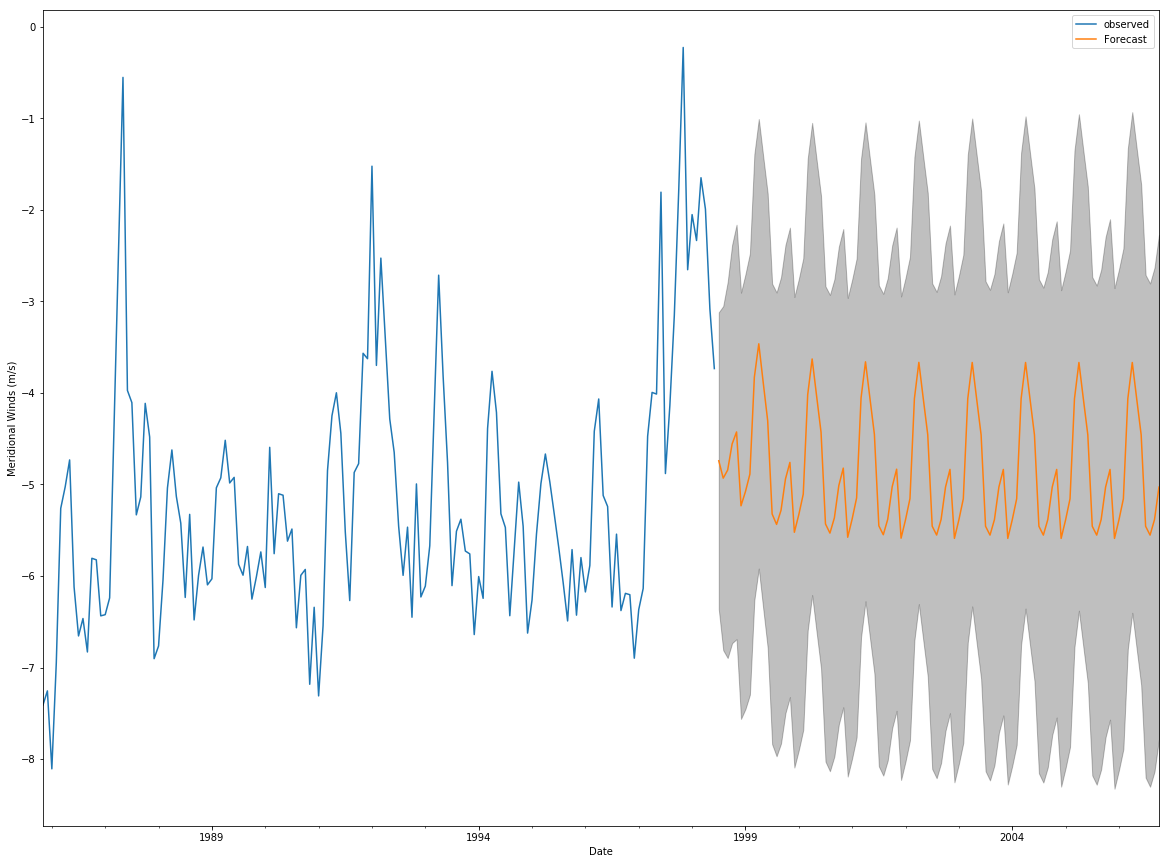

In [34]:
ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Meridional Winds (m/s)')

plt.legend()
plt.show()


# Try to understand this.

### Compare el niño vs normal periods

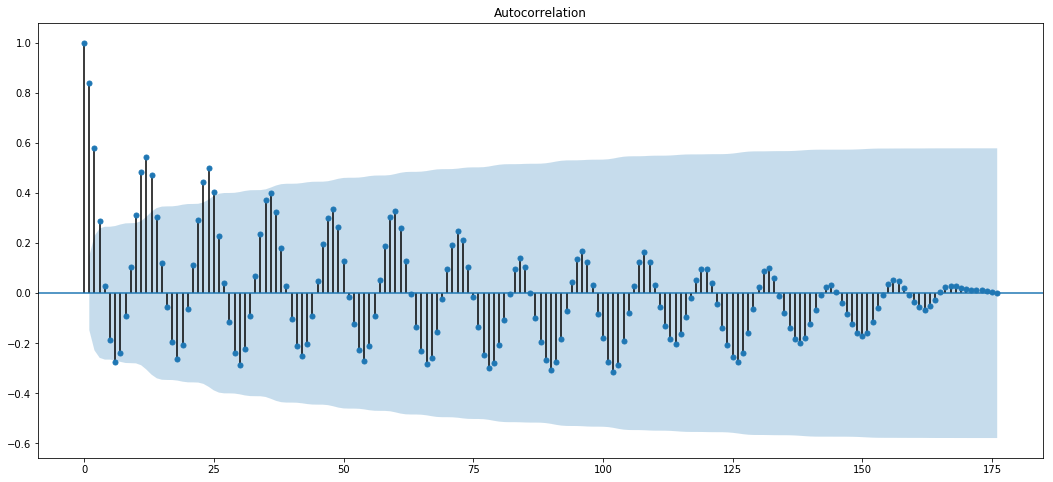

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_rev)
plt.show()

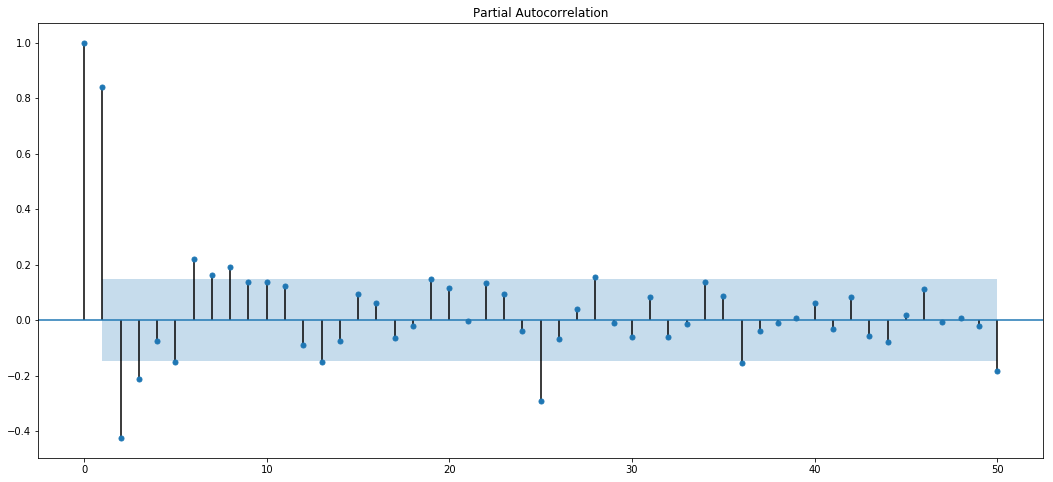

In [84]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_rev, lags=50)
plt.show()